# Exploration of Historical NBA Team Data

## About me
This is my first data science-y post... nay, blog post... nay, post of ANY kind. I work hard, but I'm also pretty lazy, which doesn't bode well in terms of communciation and organization. This probably stems from the fact that I graduated with a degree in Engineering, where our only English course amounted to **"please don't use big, scary words"**. Now, in the working world, big, scary words are all I say to abstract concepts to coworkers and clients... Who would've thought? Neither is the right way to communicate, but the answer must lie somewhere in between... I hope!

The world now surrounds us with a mind-bloggling volume of technology, and as much as I love to dive deep into tech, I also have to **feel** like I'm contributing directly to the problem I'm trying to solve (I was predisposed to think this way because I'm a millenial... RIGHT?!?). Working as a network Engineer at a big telecommunications company, it wasn't always easy to digest the fact that you may not see the fruits of your meticulous labour for **years** to come. Millenial-me kicked in and just didn't let that fly. Now, I work in a consulting role and it's quite the opposite... I'm lucky to have avoided the extremes of this situation, but in many cases, the client hires you on for a mission-critical project and you are to deliver the world to them in a few weeks. Yikes, you can definitely see the fruits of your labour, but how can you build a good solution, and let alone communicate all that?

I like to think of myself as detail-oriented. If you give me an infinite amount of time with one task, I'll take the entire time to perfect it (okay, fine, that's the hollywood version of me, but I'd still like to THINK that of myself). While that's not a bad trait, business and technology are each their own realms, with a lifetime of knowledge in either path. Now I've been given an infinite amount of time with **TWO** tasks, and thus the dilemma begins. I'm hoping for this blog to be a sandbox where I can play, experiment, and ultimately **fail** where I need to so I can optimize my approach to complex data analysis and problem solving. 

## Basketball
I follow basketball quite religiously. Favourite player? Ray Allen. Favourite team? Hometown Raptors baby. Favourite moment? Watching Kobe's 81 live. Actually now I sound like a casual fan who doesn't know what he wants or likes... ANYWAYS, I swear I'm a fanatic. I don't get to watch as many games as I'd like, but I've always been fascinated by the numbers behind it. I think in-voluntarily browsing [r/nba](http://www.reddit.com/r/nba) every 30 seconds, and occassionally opening up a/ r/nba tab while not realizing I already have an r/nba tab open from 30 seconds ago, helps. I've always wanted to pull some data together and do some analysis myself, but the paralysis strikes:
- what should I analyze?
- where should I get the data from?
- should I put it in a database?
- do I try to go big and leverage a distributed computing platform?
- maybe I can build a moneyball model of the NBA and retire in 5 years?

## Let's Just Start...
To shut myself up, I'm just going start doing __*something*__. I'm going to take some easy routes:
1. [www.basketball-reference.com](www.basketball-reference.com) seems like a good place to start to grab some data
2. let's just stick with using python and only python for now, and see where it takes us
    1. I'm hoping to find enough data at some point so I can test out Spark or Presto or something... oh god please "force" me to learn distributed computing, i'm dying for an excuse to blow my money on AWS
    
Against all best practices, I'm going to just start with no objectives and just... **go**.

---

## Ugh...
Alright, starting isn't so easy without an objective I guess. There's too much data. TOO MUCH. Again, since I don't know what I'm looking for, I'll just start at a higher level. Just about the highest level of aggregation I could go is how teams have performed historically. Maybe looking a bit at even basic stats... Points Scored... Pace... How good offense and defense is... ok sure let's do that. ¯\\_(ツ)_/¯

---

## Pulling Data
At this point I'm feeling like there's a better way to get this basketball-reference data (API of some sort?)... but I'm too deep into the script to stop scraping now. And it doesn't take __*too*__ long...

The scraping script is essentially just two loops with some housecleaning and formatting
1. Loop across each team (access the URLs of each team)
2. Within each team, we loop through across pages of stats to aggregate
    1. Base Stats
    2. Per Game
    3. Opponent Per Game

The 3 pages of stats can be found on (for example using the Toronto Raptors):
- [http://www.basketball-reference.com/teams/TOR/](http://www.basketball-reference.com/teams/TOR/)
- [http://www.basketball-reference.com/teams/TOR/stats_per_game_totals.html](http://www.basketball-reference.com/teams/TOR/stats_per_game_totals.html)
- [http://www.basketball-reference.com/teams/TOR/opp_stats_per_game_totals.html](http://www.basketball-reference.com/teams/TOR/opp_stats_per_game_totals.html)

In [2]:
# Create a dict of the pages I'm out to scrape
teamStatsBaseUrl = 'http://www.basketball-reference.com/teams/'
teamStatsUrlSuffix = {
    'baseStats': '/',
    'perGameStats': '/stats_per_game_totals.html',
    'opponentPerGameStats': '/opp_stats_per_game_totals.html'
}

In [3]:
# Notice that each page has the team embedded into the URL, create a list of all the teams to iterate through and scrape
teamList = [
    'BOS',
    'TOR',
    'NYK',
    'PHI',
    'NJN',
    'WAS',
    'ATL',
    'MIA',
    'CHA',
    'ORL',
    'CLE',
    'MIL',
    'IND',
    'CHI',
    'DET',
    'UTA',
    'OKC',
    'POR',
    'DEN',
    'MIN',
    'SAS',
    'HOU',
    'MEM',
    'NOH',
    'DAL',
    'GSW',
    'LAC',
    'SAC',
    'PHO',
    'LAL'
]

In [4]:
# Load libraries & initial config
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO

Let's start with the script. Just to outline a few data cleaning steps...
1. For some long tables, headers are repeated in the middle of the table, we remove these
2. We also see that the table has empty columns, we remove these

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/repeating_headers.png)

In [5]:
# Iterate through NBA teams to get their team stats
#   1. For each team
#       a. Get different types of stats
#       b. concatenate stats by rows (horizontally)
#   2. Aggregate stats of all teams into a single pandas dataframe (vertically)
teamAggDf = None

for team in teamList:
    teamStatsAggDf = None

#     print '\nStarting to scan {}'.format(team)
    for teamStatName, teamStatUrl in teamStatsUrlSuffix.iteritems():
        # Format URL to scan
        urlToScan = '{}{}{}'.format(
            teamStatsBaseUrl,
            team,
            teamStatUrl
        )

        # Pull data from HTML table
        #   Notice here we do not make the first row the header because we need that row of data to compare
        #   and drop duplicate headers in the middle of the table
#         print 'Checking {}'.format(urlToScan)
        teamStatsDf = pd.read_html(
            io = urlToScan,
            header = None,
            attrs = {'class': 'stats_table'}
        )[0]

        # Fix some formatting issues (extra header rows in the middle of table) from bball ref
        teamStatsDf = teamStatsDf[teamStatsDf['Season'] != 'Season']
        teamStatsDf.reset_index(inplace = True)

        # Fix some formatting issues (extra columns) from bball ref
        if u' ' in teamStatsDf.columns:
            teamStatsDf.drop(u' ', axis = 1, inplace = True)
        if u' .1' in teamStatsDf.columns:
            teamStatsDf.drop(u' .1', axis = 1, inplace = True)

        # Since we are appending data from multiple tables, we append a prefix to each column table in order to
        #   preserve which columns came frmo which tables
        teamStatsDf.columns = ['{}_{}'.format(str(teamStatName).encode('utf-8'), str(col).encode('utf-8')) for col in teamStatsDf.columns]

        # Aggregate stats dataframes
        if teamStatsAggDf is None:
            teamStatsAggDf = teamStatsDf
        else:
            teamStatsAggDf = pd.concat([teamStatsAggDf, teamStatsDf], axis = 1)

    # Aggregate stats dataframes
    if teamAggDf is None:
        teamAggDf = teamStatsAggDf
    else:
        teamAggDf = pd.concat([teamAggDf, teamStatsAggDf], axis = 0)

    print 'Finished scraping {}'.format(team)

Finished scraping BOS
Finished scraping TOR
Finished scraping NYK
Finished scraping PHI
Finished scraping NJN
Finished scraping WAS
Finished scraping ATL
Finished scraping MIA
Finished scraping CHA
Finished scraping ORL
Finished scraping CLE
Finished scraping MIL
Finished scraping IND
Finished scraping CHI
Finished scraping DET
Finished scraping UTA
Finished scraping OKC
Finished scraping POR
Finished scraping DEN
Finished scraping MIN
Finished scraping SAS
Finished scraping HOU
Finished scraping MEM
Finished scraping NOH
Finished scraping DAL
Finished scraping GSW
Finished scraping LAC
Finished scraping SAC
Finished scraping PHO
Finished scraping LAL


In [6]:
# Let's see what the dataframe looks like
print teamAggDf.dtypes

perGameStats_index            int64
perGameStats_Season          object
perGameStats_Lg              object
perGameStats_Tm              object
perGameStats_W               object
perGameStats_L               object
perGameStats_Finish          object
perGameStats_Age             object
perGameStats_Ht.             object
perGameStats_Wt.             object
perGameStats_G               object
perGameStats_MP              object
perGameStats_FG              object
perGameStats_FGA             object
perGameStats_FG%             object
perGameStats_3P              object
perGameStats_3PA             object
perGameStats_3P%             object
perGameStats_2P              object
perGameStats_2PA             object
perGameStats_2P%             object
perGameStats_FT              object
perGameStats_FTA             object
perGameStats_FT%             object
perGameStats_ORB             object
perGameStats_DRB             object
perGameStats_TRB             object
perGameStats_AST            

In [92]:
# Let's preview the dataframe itself
print teamAggDf.head()

   perGameStats_index perGameStats_Season perGameStats_Lg perGameStats_Tm  \
0                   0             2016-17             NBA             BOS   
1                   1             2015-16             NBA             BOS   
2                   2             2014-15             NBA             BOS   
3                   3             2013-14             NBA             BOS   
4                   4             2012-13             NBA             BOS   

  perGameStats_W perGameStats_L perGameStats_Finish perGameStats_Age  \
0             50             27                   1             25.9   
1             48             34                   2             25.2   
2             40             42                   2             25.0   
3             25             57                   4             25.4   
4             41             40                   3             29.1   

  perGameStats_Ht. perGameStats_Wt.        ...        baseStats_SRS  \
0              6-5              2

## Analyzing Data
There are a few garbage and repeating columns as well, I'm just going to take some that are of interest to me on first glance (real scientific, I know).

In [93]:
# First, I'll just grab some columns that look useful to me
teamAggDfToAnalyze = teamAggDf[[
    'baseStats_Season',
    'perGameStats_Tm',
    'baseStats_W',
    'baseStats_L',
    'baseStats_W/L%',
    'baseStats_SRS',
    'baseStats_Pace',
    'baseStats_Rel_Pace',
    'baseStats_ORtg',
    'baseStats_Rel_ORtg',
    'baseStats_DRtg',
    'baseStats_Rel_DRtg',
    'perGameStats_Age',
    'perGameStats_MP',
    'perGameStats_FG',
    'perGameStats_FGA',
    'perGameStats_FG%',
    'perGameStats_2P',
    'perGameStats_2PA',
    'perGameStats_2P%',
    'perGameStats_3P',
    'perGameStats_3PA',
    'perGameStats_3P%',
    'perGameStats_FT',
    'perGameStats_FTA',
    'perGameStats_FT%',
    'perGameStats_ORB',
    'perGameStats_DRB',
    'perGameStats_TRB',
    'perGameStats_AST',
    'perGameStats_STL',
    'perGameStats_BLK',
    'perGameStats_TOV',
    'perGameStats_PF',
    'perGameStats_PTS',
    'opponentPerGameStats_FG',
    'opponentPerGameStats_FGA',
    'opponentPerGameStats_FG%',
    'opponentPerGameStats_2P',
    'opponentPerGameStats_2PA',
    'opponentPerGameStats_2P%',
    'opponentPerGameStats_3P',
    'opponentPerGameStats_3PA',
    'opponentPerGameStats_3P%',
    'opponentPerGameStats_FT',
    'opponentPerGameStats_FTA',
    'opponentPerGameStats_FT%',
    'opponentPerGameStats_ORB',
    'opponentPerGameStats_DRB',
    'opponentPerGameStats_TRB',
    'opponentPerGameStats_AST',
    'opponentPerGameStats_STL',
    'opponentPerGameStats_BLK',
    'opponentPerGameStats_TOV',
    'opponentPerGameStats_PF',
    'opponentPerGameStats_PTS'
]]

# Bring season down to an integer value / single year
teamAggDfToAnalyze['season_start_year'] = teamAggDfToAnalyze['baseStats_Season'].apply(lambda x: x[:4])

# Remove spcial characters out of header
teamAggDfToAnalyze.columns = pd.Series(teamAggDfToAnalyze.columns).str.replace('%', 'Perc').str.replace('/', '')

print teamAggDfToAnalyze.dtypes

baseStats_Season                object
perGameStats_Tm                 object
baseStats_W                      int64
baseStats_L                      int64
baseStats_WLPerc               float64
baseStats_SRS                  float64
baseStats_Pace                 float64
baseStats_Rel_Pace             float64
baseStats_ORtg                 float64
baseStats_Rel_ORtg             float64
baseStats_DRtg                 float64
baseStats_Rel_DRtg             float64
perGameStats_Age                object
perGameStats_MP                 object
perGameStats_FG                 object
perGameStats_FGA                object
perGameStats_FGPerc             object
perGameStats_2P                 object
perGameStats_2PA                object
perGameStats_2PPerc             object
perGameStats_3P                 object
perGameStats_3PA                object
perGameStats_3PPerc             object
perGameStats_FT                 object
perGameStats_FTA                object
perGameStats_FTPerc      

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Phew, we have some data now. Let's try to just graph something. Let's look at raptors history.

In [94]:
rapsDf = teamAggDfToAnalyze[teamAggDfToAnalyze['perGameStats_Tm'] == 'TOR']
print rapsDf.shape

(22, 57)


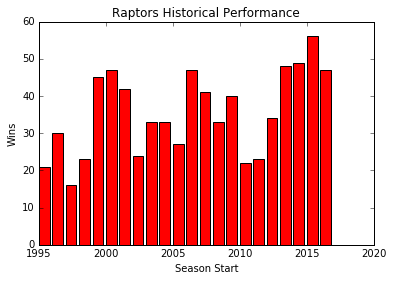

In [95]:
plt.bar(
    rapsDf['season_start_year'].tolist(), 
    rapsDf['baseStats_W'].tolist(),
    color = 'red'
)
plt.xlabel('Season Start')
plt.ylabel('Wins')
plt.title('Raptors Historical Performance')
 
plt.show()

We can see three spikes... These seem to represent the Vince Carter, Chris Bosh, and KLow / DD eras.

I know that there are two lockout seasons in there as well so that may throw the visual results off a little bit. Let's use Win% instead.

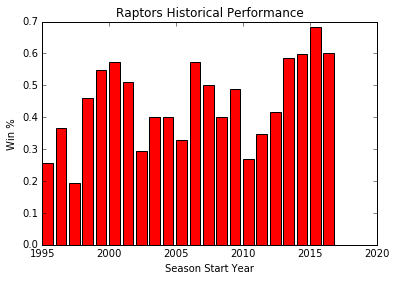

In [96]:
plt.bar(
    rapsDf['season_start_year'].tolist(), 
    rapsDf['baseStats_WLPerc'].tolist(),
    color = 'red'
)
plt.xlabel('Season Start Year')
plt.ylabel('Win %')
plt.title('Raptors Historical Performance')
 
plt.show()

How do you win games? POINTS! Let's see if scoring points matters in wins... at least for the raptors.

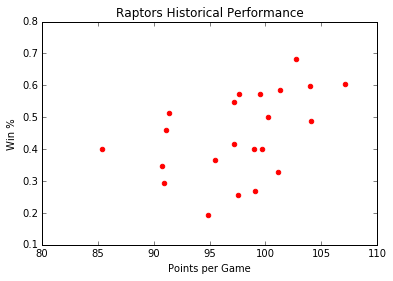

In [97]:
plt.scatter(
    rapsDf['perGameStats_PTS'].tolist(), 
    rapsDf['baseStats_WLPerc'].tolist(),
    color = 'red'
)
plt.xlabel('Points per Game')
plt.ylabel('Win %')
plt.title('Raptors Historical Performance')
 
plt.show()

Pretty much no correlation... small sample size perhaps?

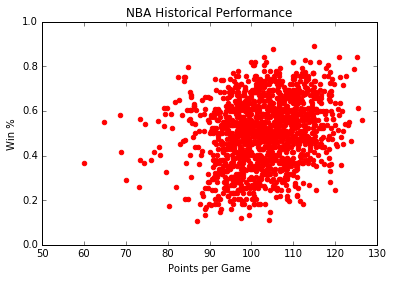

In [98]:
plt.scatter(
    teamAggDfToAnalyze['perGameStats_PTS'].tolist(), 
    teamAggDfToAnalyze['baseStats_WLPerc'].tolist(),
    color = 'red'
)
plt.xlabel('Points per Game')
plt.ylabel('Win %')
plt.title('NBA Historical Performance')
 
plt.show()

Nope, haha. This makes sense, I can't expect to moneyball it after one very obvious metric. After all, I've seen games where we've scored 120 and lost, and scored 70 and won (okay fine, I don't remember a SPECIFIC example... but it's happened in the league before).

---

## Efficiency
Anyone can score 120. The run and gun suns averaged 110 during the D'Antoni era, and 120 dating back to the 80s and 90s (Barkley...? I'm not sure I'm too young and naive).

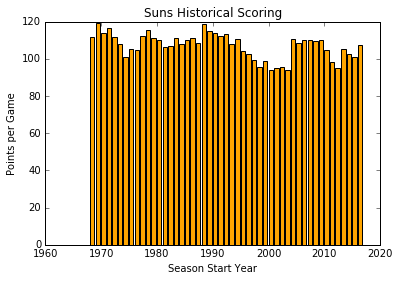

In [99]:
sunsDf = teamAggDfToAnalyze[teamAggDfToAnalyze['perGameStats_Tm'] == 'PHO']

plt.bar(
    sunsDf['season_start_year'].tolist(), 
    sunsDf['perGameStats_PTS'].tolist(),
    color = 'orange'
)
plt.xlabel('Season Start Year')
plt.ylabel('Points per Game')
plt.title('Suns Historical Scoring')
 
plt.show()

If I play pick up and just jack up 3's, I'm probably going to score a ton. Doesn't necessarily mean I win though:
- I have to be efficient while doing it (If i'm taking 3 shots to get a 3 while my opponent scores every possession, they will win)
- I have to also be playing defense (duh)

At the end of the day, if I'm scoring more efficiently than my opponent. I win! Ignoring 3's for now, if I score 50/100 possessions of the game, and my opponent scores 49/100, I win.

Instead of looking at scoring, let's look at **Offensive Rating** instead:

$$ORtg=\frac{Points\ Scored}{100\ Possessions}$$

While we're at it, let's just define **Defensive Rating** too:

$$DRtg=\frac{Points\ Allowed}{100\ Possessions}$$

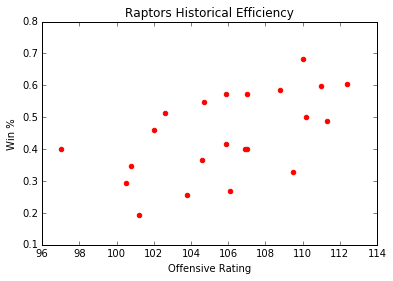

In [100]:
plt.scatter(
    rapsDf['baseStats_ORtg'].tolist(), 
    rapsDf['baseStats_WLPerc'].tolist(),
    color = 'red'
)
plt.xlabel('Offensive Rating')
plt.ylabel('Win %')
plt.title('Raptors Historical Efficiency')
 
plt.show()

Hmm, I thought that would work. Guess not. Still looks pretty garbage. Perhaps even **worse**. Hail mary... small sample size?

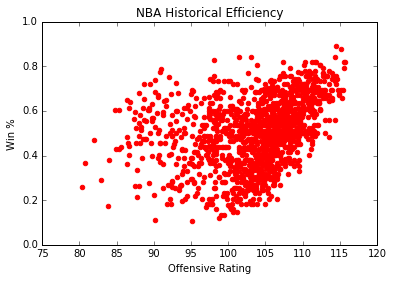

In [101]:
plt.scatter(
    teamAggDfToAnalyze['baseStats_ORtg'].tolist(), 
    teamAggDfToAnalyze['baseStats_WLPerc'].tolist(),
    color = 'red'
)
plt.xlabel('Offensive Rating')
plt.ylabel('Win %')
plt.title('NBA Historical Efficiency')
 
plt.show()

_**Maybe**_ better? Not quite sure... Ok, maybe I'm getting a bit _**too**_ ahead of myself here... Let's get back to the gist of my earlier theory on efficiency. If your efficiency, on average, is much greater than your opponents, you **MUST** be winning RIGHT?

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


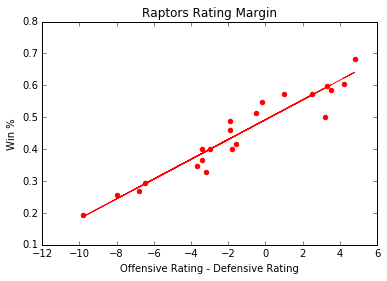

In [102]:
# Get the rating margin defined as ORtg - DRtg
teamAggDfToAnalyze['rtg_diff'] = teamAggDfToAnalyze['baseStats_ORtg'] - teamAggDfToAnalyze['baseStats_DRtg']
rapsDf = teamAggDfToAnalyze[teamAggDfToAnalyze['perGameStats_Tm'] == 'TOR']

plt.scatter(
    rapsDf['rtg_diff'].tolist(), 
    rapsDf['baseStats_WLPerc'].tolist(),
    color = 'red'
)
plt.xlabel('Offensive Rating - Defensive Rating')
plt.ylabel('Win %')
plt.title('Raptors Rating Margin')

# Plot best fit line as well
m, b = np.polyfit(
    rapsDf['rtg_diff'].tolist(), 
    rapsDf['baseStats_WLPerc'].tolist(),
    1
)

plt.plot(
    rapsDf['rtg_diff'].tolist(), 
    (m*rapsDf['rtg_diff'] + b).tolist(),
    '-',
    color = 'red',
)

plt.show()

And for the whole league?

C:\Users\chixwang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


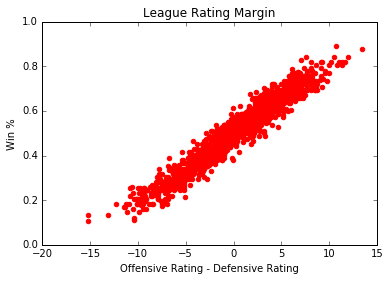

In [103]:
# Get the rating margin defined as ORtg - DRtg
teamAggDfToAnalyze['rtg_diff'] = teamAggDfToAnalyze['baseStats_ORtg'] - teamAggDfToAnalyze['baseStats_DRtg']

plt.scatter(
    teamAggDfToAnalyze['rtg_diff'].tolist(), 
    teamAggDfToAnalyze['baseStats_WLPerc'].tolist(),
    color = 'red'
)
plt.xlabel('Offensive Rating - Defensive Rating')
plt.ylabel('Win %')
plt.title('League Rating Margin')

Thank god. This is finally  making a bit of sense. I just needed to know that I wasn't insane and that basketball is just complex in it's nature. Ok whatever fine both points are true.

In [104]:
# Check covariance of rtg_diff
np.cov(
    rapsDf['rtg_diff'].tolist(), 
    rapsDf['baseStats_WLPerc'].tolist()
)[0, 1]

0.51563766233766239

In [105]:
# And if we compare this to just ORtg...
np.cov(
    rapsDf['baseStats_ORtg'].tolist(), 
    rapsDf['baseStats_WLPerc'].tolist()
)[0, 1]

0.29637965367965369

This leaves more to be desired, but at the same time, it is **much** better than our original predictor. I've determined that if I score points more efficiently than my opponent, I win! I feel so accomplished... where's my  moneyball cheque?

Visual representation of my analysis so far:

<img src = "http://www.raps.org/uploadedImages/Site_Setup/Regulatory_Focus/News/2015/03/Iceberg.jpg" style = "width: 200px;"/>

Actually, I think that's an insult to both basketball and the iceberg. My actual progress:

<img src = "http://www.snopes.com/photos/politics/graphics/binoc6.jpg" style = "width: 400px;"/>

Okay, so now we come to 2 more questions. What affects ORtg? What affects DRtg?

We defined these earlier in this anaylsis as simply the amount of points you score and the amount of points you allow per 100 possessions. 100 is roughly the amount of possessions exchanged in a game. I'm sure 100 was picked because of that and the fact that it's a nice round number, but we can see that when we normalize the metric for possessions, it becomes a bit more meaningful to us.

## Conclusion
That's it for now. One of my objectives was clearer communication, so I should probably stop packing more content into this one notebook. Some would scoff and say it's a lost cause already, and to those people, I scoff with you! But I'm a huge proponent of taking 80 steps back before taking 1 step forward!

Below, we just save our dataframe to S3 so we don't have to spend the 5 minutes to scrape all the data again (and I'm sure basketball-reference wouldn't be happy about that).

In [107]:
# Save data to S3 so we can use it for future analysis
csv_buffer = StringIO()
teamAggDfToAnalyze.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object('2017edmfasatb', 'fas_boto/data/teamAggDfToAnalyze.csv').put(Body=csv_buffer.getvalue())

{u'ETag': '"5205ca3830bd89818fc7e480fa98c5d3"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Mon, 10 Apr 2017 17:46:49 GMT',
   'etag': '"5205ca3830bd89818fc7e480fa98c5d3"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'vH4whzK1nyI007b7idzhbWaQZM++k5yFwny8VCsY+g734/OIS0dvyQvs24Cxs6XCPv9vC4omLhA=',
   'x-amz-request-id': '3910C3490B4844AC'},
  'HTTPStatusCode': 200,
  'HostId': 'vH4whzK1nyI007b7idzhbWaQZM++k5yFwny8VCsY+g734/OIS0dvyQvs24Cxs6XCPv9vC4omLhA=',
  'RequestId': '3910C3490B4844AC',
  'RetryAttempts': 0}}